In [1]:
import jax.numpy as jnp

from jax import random
from jax.example_libraries import optimizers
from jax import jit, grad, vmap

import functools

import neural_tangents as nt
from neural_tangents import stax

from tqdm import tqdm

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib
import seaborn as sns

sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})

import matplotlib.pyplot as plt

def format_plot(x=None, y=None):
  # plt.grid(False)
  ax = plt.gca()
  if x is not None:
    plt.xlabel(x, fontsize=20)
  if y is not None:
    plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

legend = functools.partial(plt.legend, fontsize=10)

def plot_fn(train, test, *fs):
  train_xs, train_ys = train

  plt.plot(train_xs, train_ys, 'ro', markersize=10, label='train')

  if test != None:
    test_xs, test_ys = test
    plt.plot(test_xs, test_ys, 'k--', linewidth=3, label='$f(x)$')

    for f in fs:
      plt.plot(test_xs, f(test_xs), '-', linewidth=3)

  plt.xlim([-jnp.pi, jnp.pi])
  plt.ylim([-1.5, 1.5])

  format_plot('$x$', '$f$')

C:\Users\Yudi\AppData\Local\Temp\ipykernel_18996\1909444407.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


In [3]:
key = random.PRNGKey(10)

train_points = 20
test_points = 100
noise_scale = 1e-1

target_fn = lambda x: jnp.sin(x)


key, x_key, y_key = random.split(key, 3)

train_xs = random.uniform(x_key, (train_points, 1), minval=-jnp.pi, maxval=jnp.pi)

train_ys = target_fn(train_xs)
train_ys += noise_scale * random.normal(y_key, (train_points, 1))
train = (train_xs, train_ys)


test_xs = jnp.linspace(-jnp.pi, jnp.pi, test_points)
test_xs = jnp.reshape(test_xs, (test_points, 1))

test_ys = target_fn(test_xs)
test = (test_xs, test_ys)

In [4]:
def create_network(width=512):
    """Create neural network with given width."""
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(width, W_std=1, b_std=0.1, parameterization='ntk'), stax.Erf(),
        stax.Dense(width, W_std=1, b_std=0.1, parameterization='ntk'), stax.Erf(),
        stax.Dense(1, W_std=1, b_std=0.1, parameterization='ntk')
    )
    
    apply_fn = jit(apply_fn)
    kernel_fn = jit(kernel_fn, static_argnames='get')
    
    impl = nt.NtkImplementation.JACOBIAN_CONTRACTION if width < 1024 else nt.NtkImplementation.STRUCTURED_DERIVATIVES
    
    ntk_fn = nt.empirical_ntk_fn(
        f=apply_fn,
        implementation=impl,
        trace_axes=(),
        vmap_axes=0
    )
    ntk_fn = jit(ntk_fn)
    
    return init_fn, apply_fn, kernel_fn, ntk_fn

In [5]:
def train_network(key, init_fn, apply_fn, ntk_fn, opt_init, opt_update, get_params, 
                  loss, grad_loss, training_steps, ntk_eval_frequency, train, test):
    """Training function for different network setting."""
    train_losses = []
    test_losses = []
    kernel = {}
    
    # Initialize network
    _, params = init_fn(key, (-1, 1))
    opt_state = opt_init(params)
    
    # Compute initial NTK
    ntk_init = ntk_fn(train[0], train[0], params)
    kernel[0] = ntk_init
    
    # Training loop
    for i in tqdm(range(training_steps)):
        # Training step
        train_losses += [jnp.reshape(loss(get_params(opt_state), *train), (1,))]
        test_losses += [jnp.reshape(loss(get_params(opt_state), *test), (1,))]
        opt_state = opt_update(i, grad_loss(opt_state, *train), opt_state)
        
        # Compute NTK
        if (i+1) % ntk_eval_frequency == 0 or i == training_steps - 1:
            current_params = get_params(opt_state)
            current_ntk = ntk_fn(train[0], train[0], current_params)
            kernel[i+1] = current_ntk
    
    train_losses = jnp.concatenate(train_losses)
    test_losses = jnp.concatenate(test_losses)
    
    return get_params(opt_state), train_losses, test_losses, kernel

Empirical NTK stability

In [6]:
def compute_stability_metrics(kernel):
    """Compute NTK stability metrics during training."""
    steps = sorted(list(kernel.keys()))
    
    # Extract and reshape initial kernel to ensure correct dimensionality
    K_init = jnp.asarray(kernel[0])
    K_init = jnp.squeeze(K_init)
    
    metrics = {
        'steps': [],
        'rel_frobenius': [],  # Global kernel deviation
        'rel_spectral': []   # Maximum directional distortion
    }
    
    for step in steps:
        if step == 0:
            continue
            
        # Extract and reshape current kernel
        K_t = jnp.asarray(kernel[step])
        K_t = jnp.squeeze(K_t)
        
        # Relative Frobenius norm: ||K_t - K_0||_F / ||K_0||_F
        frob_norm_diff = jnp.linalg.norm(K_t - K_init)
        frob_norm_init = jnp.linalg.norm(K_init)
        rel_frob = frob_norm_diff / frob_norm_init
        
        # Compute eigenvalues
        eig_t = jnp.linalg.eigvalsh(K_t)
        eig_init = jnp.linalg.eigvalsh(K_init)
        
        # Compute spectral metrics
        spectral_diff = jnp.max(jnp.abs(eig_t - eig_init))
        spectral_init = jnp.max(jnp.abs(eig_init))
        rel_spectral = spectral_diff / spectral_init
        
        metrics['steps'].append(step)
        metrics['rel_frobenius'].append(float(rel_frob))
        metrics['rel_spectral'].append(float(rel_spectral))
    
    return metrics

In [7]:
def compute_eigenspectra(kernel, num_snapshot_steps=5):
    """Extract eigenvalue spectrum at different training stage."""
    steps = sorted(list(kernel.keys()))
    
    # Select steps evenly throughout training
    if len(steps) <= num_snapshot_steps:
        snapshot_steps = steps
    else:
        indices = jnp.linspace(0, len(steps)-1, num_snapshot_steps, dtype=int)
        snapshot_steps = [steps[i] for i in indices]
    
    eigenspectra = {}
    for step in snapshot_steps:
        # Extract and reshape kernel
        K = jnp.asarray(kernel[step])
        K = jnp.squeeze(K)
        
        # Compute eigenvalues efficiently with JAX's specialized eigvalsh function
        eigenvals = jnp.linalg.eigvalsh(K)
        # Sort in descending order for better visualization
        eigenvals = eigenvals[::-1]
        eigenspectra[step] = eigenvals
        
    return eigenspectra

In [8]:
def width_experiment(widths, seed=10, training_steps=10000, ntk_eval_frequency=100):
    """Run NTK stability experiments across multiple widths."""
    key = random.PRNGKey(seed)
    learning_rate = 0.1
    
    # Compile results
    results = {}
    
    for width in widths:
        print(f"Running experiment with width {width}")
        # Create width-specific network
        init_fn, apply_fn, _, ntk_fn = create_network(width)
        
        # Optimizer configuration - reused from your existing code
        opt_init, opt_update, get_params = optimizers.sgd(learning_rate)
        opt_update = jit(opt_update)
        
        # Loss function - reused from your existing code
        loss = jit(lambda params, x, y: 0.5 * jnp.mean((apply_fn(params, x) - y) ** 2))
        grad_loss = jit(lambda state, x, y: grad(loss)(get_params(state), x, y))
        
        # Run training with this width configuration
        key_i = random.fold_in(key, width)  # Create a unique key derived from width
        params, train_loss, test_loss, kernel = train_network(key_i, init_fn, apply_fn, ntk_fn, 
                                                             opt_init, opt_update, get_params,
                                                             loss, grad_loss, training_steps, 
                                                             ntk_eval_frequency, train, test)
        
        # Compute stability metrics
        metrics = compute_stability_metrics(kernel)
        eigenspectra = compute_eigenspectra(kernel, num_snapshot_steps=5)
        
        # Store results
        results[width] = {
            'params': params,
            'train_loss': train_loss,
            'test_loss': test_loss,
            'kernel': kernel,
            'metrics': metrics,
            'eigenspectra': eigenspectra
        }
    
    return results

In [9]:
def plot_frobenius_by_width(width_results):
    """Plot relative Frobenius distance across different widths."""
    plt.figure(figsize=(10, 6))
    
    for width, results in width_results.items():
        metrics = results['metrics']
        plt.plot(metrics['steps'], metrics['rel_frobenius'], label=f'Width {width}')
    
    plt.xlabel('Training Step')
    plt.ylabel('Relative Frobenius Distance')
    plt.title('NTK Stability vs. Network Width')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    return plt.gcf()

def plot_final_metrics_by_width(width_results):
    """Plot final stability metrics as a function of network width."""
    widths = sorted(list(width_results.keys()))
    
    # Extract final metrics for each width
    final_frob = [width_results[w]['metrics']['rel_frobenius'][-1] for w in widths]
    final_spectral = [width_results[w]['metrics']['rel_spectral'][-1] for w in widths]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].plot(widths, final_frob, 'o-')
    axes[0].set_xlabel('Network Width')
    axes[0].set_ylabel('Final Relative Frobenius')
    axes[0].set_title('Kernel Stability vs. Width')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(widths, final_spectral, 'o-')
    axes[1].set_xlabel('Network Width')
    axes[1].set_ylabel('Final Relative Spectral')
    axes[1].set_title('Directional Stability vs. Width')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def plot_eigenvalue_comparison(width_results, step_idx=-1):
    """Compare eigenspectra across widths at a specific training stage."""
    plt.figure(figsize=(10, 6))
    
    for width, results in width_results.items():
        eigenspectra = results['eigenspectra']
        steps = sorted(list(eigenspectra.keys()))
        selected_step = steps[step_idx]  # Default to last step
        
        # Get top 20 eigenvalues
        eigenvals = eigenspectra[selected_step][:20]
        indices = jnp.arange(len(eigenvals))
        
        plt.plot(indices, eigenvals, 'o-', label=f'Width {width}')
    
    plt.xlabel('Eigenvalue Index')
    plt.ylabel('Eigenvalue Magnitude (log scale)')
    plt.title(f'NTK Eigenspectrum Comparison Across Widths (Step {selected_step})')
    plt.legend()
    plt.yscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    
    return plt.gcf()

Running experiment with width 64


100%|██████████| 10000/10000 [00:01<00:00, 9907.19it/s]
c:\Users\Yudi\anaconda3\Lib\site-packages\jax\_src\numpy\lax_numpy.py:6944: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
c:\Users\Yudi\anaconda3\Lib\site-packages\jax\_src\numpy\lax_numpy.py:6945: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  stop = asarray(stop, dtype=computation_dtype)
c:\Users\Yudi\anaconda3\Lib\site-packages\jax\_src\numpy\lax_numpy.py:6954: UserWarnin

Running experiment with width 128


100%|██████████| 10000/10000 [00:02<00:00, 4862.38it/s]


Running experiment with width 256


100%|██████████| 10000/10000 [00:06<00:00, 1499.43it/s]


Running experiment with width 512


100%|██████████| 10000/10000 [00:23<00:00, 424.30it/s]


Running experiment with width 1024


100%|██████████| 10000/10000 [01:10<00:00, 142.38it/s]


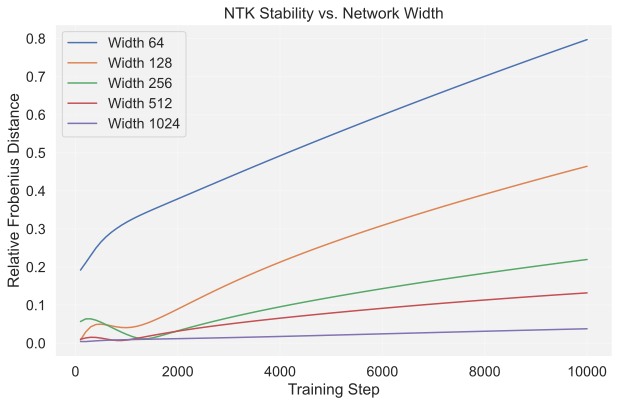

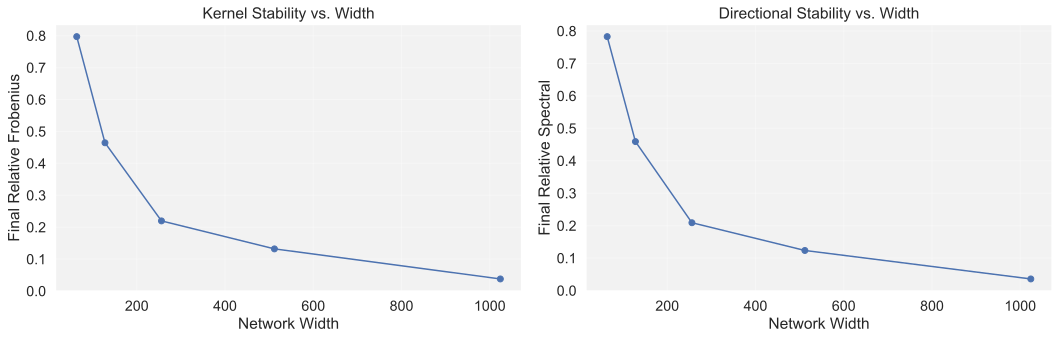

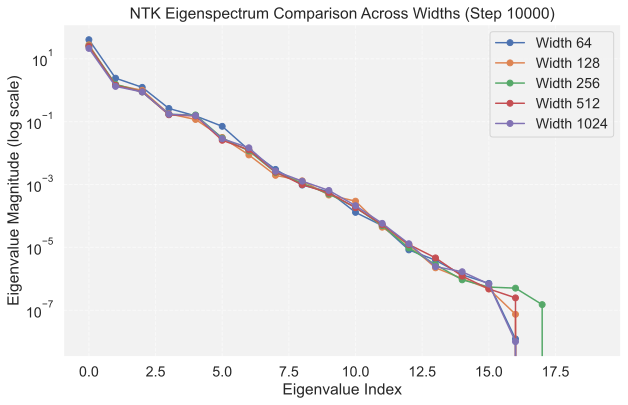

In [10]:
# Define widths to test
widths = [64, 128, 256, 512, 1024]

# Run experiments (can take a while)
width_results = width_experiment(widths, 
                                    seed=10, 
                                    training_steps=10000,  # Reduced for faster execution
                                    ntk_eval_frequency=100)

# Generate comparative visualizations
frob_fig = plot_frobenius_by_width(width_results)
metrics_fig = plot_final_metrics_by_width(width_results)
eigen_fig = plot_eigenvalue_comparison(width_results)

# Display figures
plt.show()